In [26]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [27]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0


In [28]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64061 entries, 0 to 64060
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64061 non-null  object 
 1   Hour        64061 non-null  object 
 2   Waterlevel  64061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [30]:
df.isnull().sum()

Date          0
Hour          0
Waterlevel    0
dtype: int64

In [31]:
# df.loc[df['Hour'] == 'NUM!', 'Hour'] = 0
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [32]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


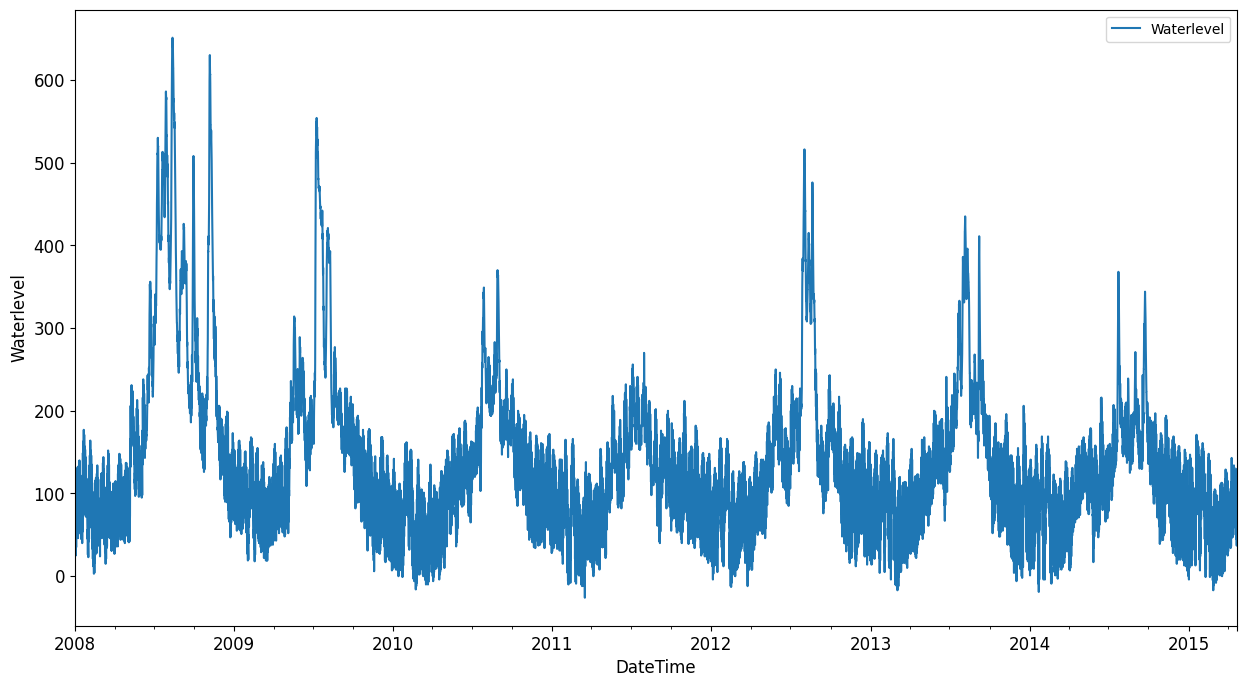

In [33]:
df.plot(y='Waterlevel', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)
plt.show()

In [34]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]

train, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2015-04-23 00:00:00       127.0
 2015-04-23 01:00:00       124.0
 2015-04-23 02:00:00       120.0
 2015-04-23 03:00:00       115.0
 2015-04-23 04:00:00       109.0
 
 [19219 rows x 1 columns])

In [35]:
train.shape, test.shape

((44842, 1), (19219, 1))

Text(0, 0.5, 'Waterlevel')

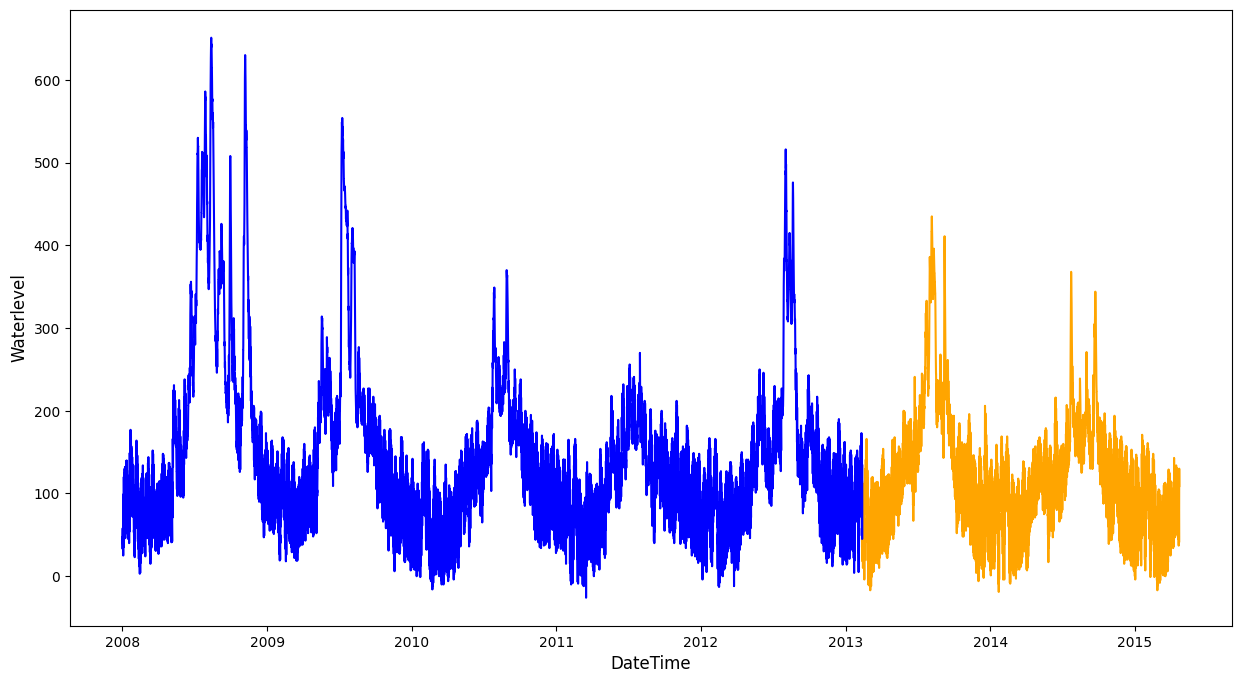

In [36]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [37]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)

In [38]:
test['Waterlevel'] = scaler.transform(test)

In [39]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [40]:
timesteps=5

In [41]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(44838, 5)

In [42]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(19215, 5)

In [43]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(44838, 4) (44838, 1)
(19215, 4) (19215, 1)


# KNN

In [44]:
from sklearn.neighbors import KNeighborsRegressor
# Initialize and train the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(x_train, y_train)

KNeighborsRegressor()

In [45]:
y_train_pred_knn = knn_regressor.predict(x_train).reshape(-1,1)
y_test_pred_knn = knn_regressor.predict(x_test).reshape(-1,1)

print(y_train_pred_knn.shape, y_test_pred_knn.shape)

(44838, 1) (19215, 1)


In [46]:
# Scaling the predictions
y_train_pred_knn = scaler.inverse_transform(y_train_pred_knn)
y_test_pred_knn = scaler.inverse_transform(y_test_pred_knn)

print(len(y_train_pred_knn), len(y_test_pred_knn))

44838 19215


In [47]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

44838 19215


In [48]:
train_timestamps = train.index[timesteps-1:]
test_timestamps = test.index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

44838 19215


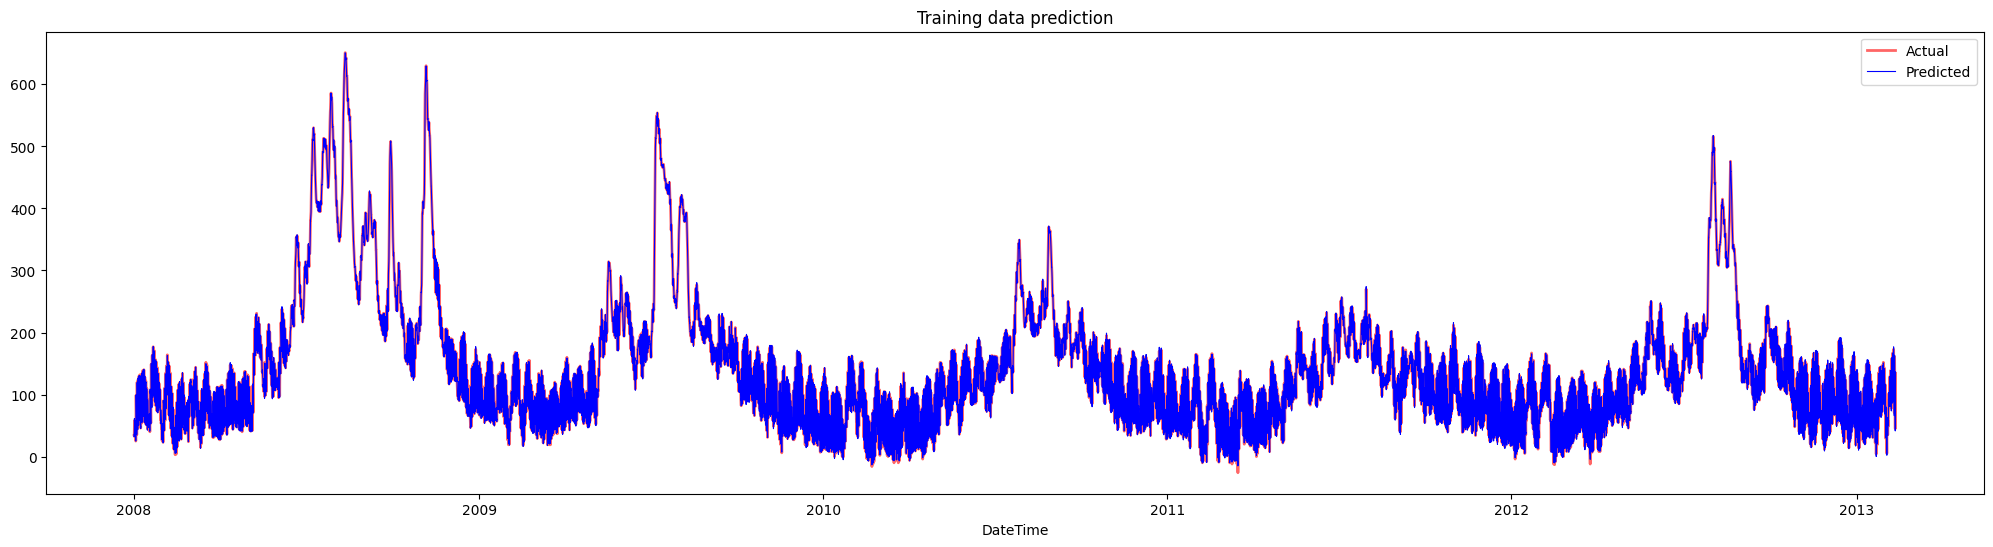

In [49]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_knn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DateTime')
plt.title("Training data prediction")
plt.show()

In [50]:
mae = mean_absolute_error(y_train, y_train_pred_knn)
print("MAE:", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
print("RMSE:", rmse)

# Tính R² Score
r2 = r2_score(y_train, y_train_pred_knn)
print("R²:", r2)

# Tính NSE
def nse(y_train, y_train_pred_knn):
    return 1 - np.sum((y_train_pred_knn - y_train) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)

nse_value = nse(y_train, y_train_pred_knn)
print("NSE:", nse_value)

MAE: 1.322177617199697
RMSE: 1.981768569735216
R²: 0.9996437012621633
NSE: 0.9996437012621633


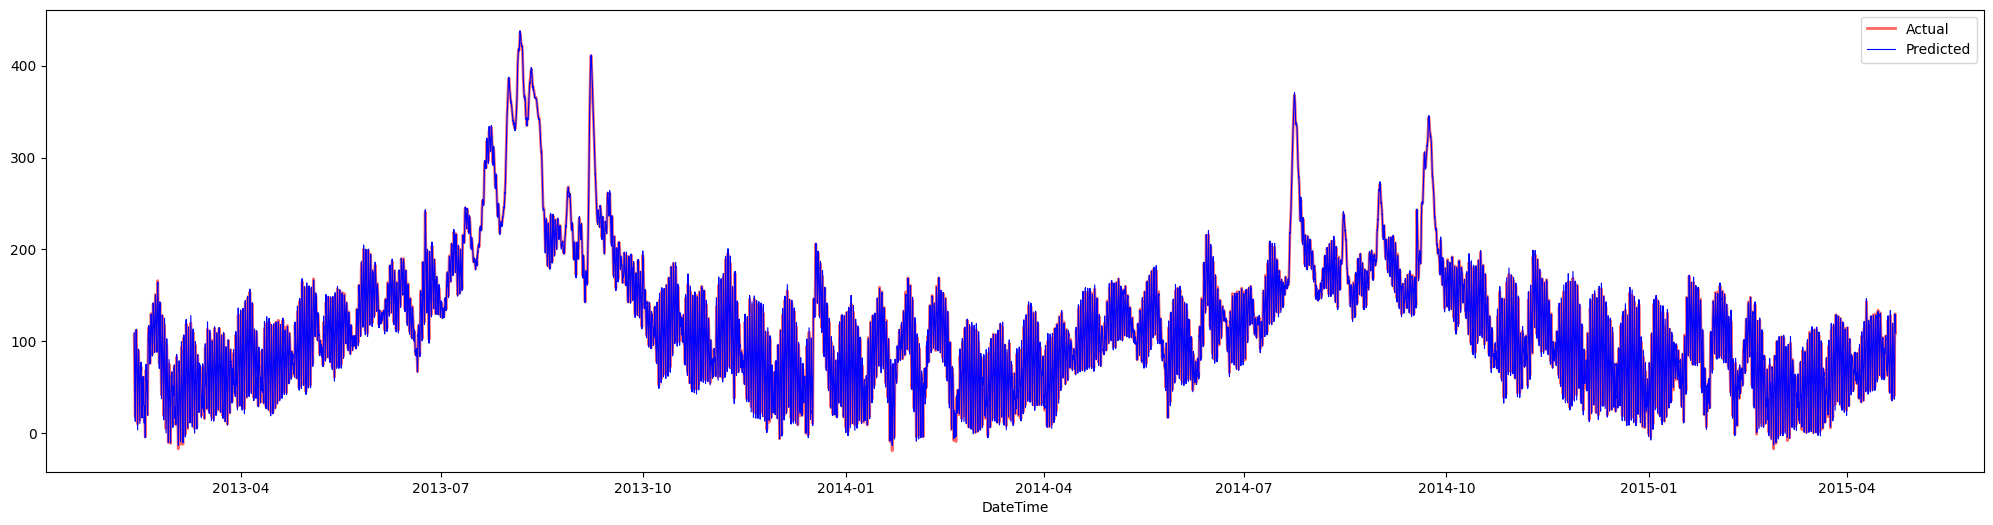

In [51]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_knn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DateTime')
plt.show()

In [52]:
mae = mean_absolute_error(y_test, y_test_pred_knn)
print("MAE:", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
print("RMSE:", rmse)

# Tính R² Score
r2 = r2_score(y_test, y_test_pred_knn)
print("R²:", r2)

# Tính NSE
def nse(y_test, y_test_pred_knn):
    return 1 - np.sum((y_test_pred_knn - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

nse_value = nse(y_test, y_test_pred_knn)
print("NSE:", nse_value)

MAE: 1.816055165235493
RMSE: 2.6733268701703716
R²: 0.9986284172641771
NSE: 0.9986284172641771


In [54]:
y_test_flat_knn = y_test.flatten()
y_test_pred_flat_knn = y_test_pred_knn.flatten()

# Tạo DataFrame với chỉ số là test_timestamps
df = pd.DataFrame({'Actual': y_test_flat_knn, 'Predicted': y_test_pred_flat_knn}, index=test_timestamps)

# Hiển thị DataFrame
df

,Actual,Predicted
DateTime,,
2013-02-11 14:00:00,107.0,109.6
2013-02-11 15:00:00,99.0,99.4
2013-02-11 16:00:00,91.0,92.4
2013-02-11 17:00:00,82.0,83.4
2013-02-11 18:00:00,74.0,74.8
...,...,...
2015-04-23 00:00:00,127.0,125.0
2015-04-23 01:00:00,124.0,123.6
2015-04-23 02:00:00,120.0,120.8
